In [ ]:
%load_ext autoreload
%autoreload 2
import machine_common_sense as mcs
from generate_data import make_rgb_point_cloud_ball, mask_rgb_to_id, get_id_from_masks, filter_unique_depths, soccer_ball_in_ids
from jax import numpy as jnp
import jax
from PIL import Image
import numpy as onp
from matplotlib import pyplot as plt
from flax_transformer import TransformerConfig
from train_transformer import initialize_model, load_chkpt
from jax.random import PRNGKey
from functools import partial
from matplotlib.gridspec import GridSpec
import math

In [17]:
@partial(jax.jit, static_argnums=(2,))
def make_centered_padded_data(d_masked, r_masked, MAX_SIZE):
    size = d_masked.shape[1]
    d_centered = d_masked - d_masked.mean(axis=1)[:, None]

    data_mask = jnp.zeros((MAX_SIZE,), dtype=jnp.uint8)
    data_mask = data_mask.at[0:size].set(True)

    data_depth = jnp.zeros((3,MAX_SIZE,))
    data_depth = data_depth.at[:, 0:size].set(d_centered)

    data_rgb = jnp.zeros((3,MAX_SIZE,),dtype=jnp.float32,)
    data_rgb = data_rgb.at[:, 0:size].set(r_masked)
    return data_depth, data_rgb, data_mask

In [18]:
#load the transformer
t_cfg = TransformerConfig(
    num_heads= 4,
    num_enc_layers=1,
    num_dec_layers=1,
    dropout_rate=0.1,
    deterministic=True,
    d_model=32, #should be a multiple of the number of heads.
    add_positional_encoding=False,
    obs_emb_hidden_sizes=(120,),
    num_latents=1
  )
eval_m, _, _ = initialize_model(key=PRNGKey(6734),obs_length=400,num_input_vars=6,t_cfg=t_cfg)
params, _, _ = load_chkpt(2, "chkpts/")

In [19]:
controller = mcs.create_controller("sample_config.ini")
scene_data = mcs.load_scene_json_file(f'./spatial_elimination_eval_5_ex_2.json')
s = controller.start_scene(scene_data)

Found path: /home/aldo/.mcs/0.6.1/MCS-AI2-THOR-Unity-App-v0.6.1.x86_64


In [20]:
def process_data(s, ball_color):
    d, r, ids = make_rgb_point_cloud_ball(
            ball_mask_rgb=ball_color,
            mask= jnp.asarray(s.object_mask_list[-1]),
            rgb= jnp.asarray(s.image_list[-1]),
            depth= jnp.asarray(s.depth_map_list[-1]),
            aspect_ratio=jnp.array(s.camera_aspect_ratio),
            field_of_view=s.camera_field_of_view,
            voxel_res=0.04,
        )
    r = r.astype(onp.float32)
    print(r.max(), r.min())
    v_d, v_r, v_m = filter_unique_depths(d, r, ids)
    return v_d, v_r, v_m

def process_object(obj_id,mask):
    o_d, o_r = v_d[:, mask], v_r[:, mask]
    p_d, p_r, p_m = make_centered_padded_data(o_d, o_r, 2000)
    colored_pc = jnp.concatenate([p_r,p_d]).T[None]
    return colored_pc

255.0 17.0
255.0 1.0
no soccer 1
255.0 16.0
255.0 15.0
no soccer 3
238.0 16.0
no soccer 4
236.0 15.0
255.0 18.0


KeyboardInterrupt: 

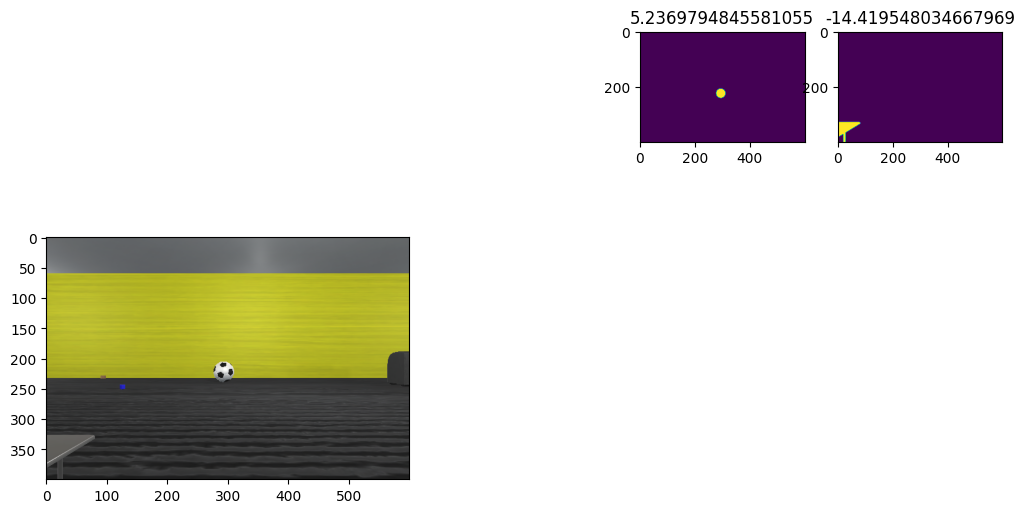

In [22]:
file_paths = [f'./spatial_elimination_eval_5_ex_2.json'] + [f'ball_scenes_bk_2/pr_10_{i:06}.json' for i in range(1000,2200)]

big_size = 3
num_cols = 5
j = 0

for i,im in enumerate(file_paths):
    
    scene_data = mcs.load_scene_json_file(im)
    s = controller.start_scene(scene_data)
    
    ball_id = scene_data["goal"]["metadata"]["target"]["id"]
    b = [o for o in s.segmentation_colors if o["objectId"] == ball_id][0]
    ball_color = jnp.array((b["r"], b["g"], b["b"]), dtype=jnp.uint8)
    
    v_d, v_r, v_m = process_data(s, ball_color)
    
    all_ids = jnp.unique(v_m)
    added = 0
    ids_im = jax.vmap(jax.vmap(get_id_from_masks, in_axes=(None, 0)), in_axes=(None, 0))(
        ball_color, jnp.asarray(s.object_mask_list[-1])
    )
    
    soccer_mask = v_m == 0
    if soccer_mask.sum()<10:
        print('no soccer', i)
        continue
    
    fig = plt.figure(figsize=(20,10))
    fig.tight_layout()
    gs = GridSpec(nrows=3, ncols=big_size + num_cols)
    ax0 = fig.add_subplot(gs[:,:big_size-1])
    ax0.imshow(s.image_list[-1])
    for o,im_id in enumerate(all_ids):
        mask = (v_m == im_id)
        if mask.sum()>500:
            continue
        colored_pc = process_object(im_id, mask)
        pred_logit = eval_m.apply({'params':params}, colored_pc).item()
        ax = fig.add_subplot(gs[math.floor(added/2), big_size + (added % 2)])
        ax.imshow(ids_im==im_id)
        ax.title.set_text(f'{pred_logit}')
        added += 1
        if added >5:
            break
    fig.savefig(f'panels/im_{j}.png')
    plt.close()
    j += 1

127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0
127.0 -128.0
-128.0 127.0


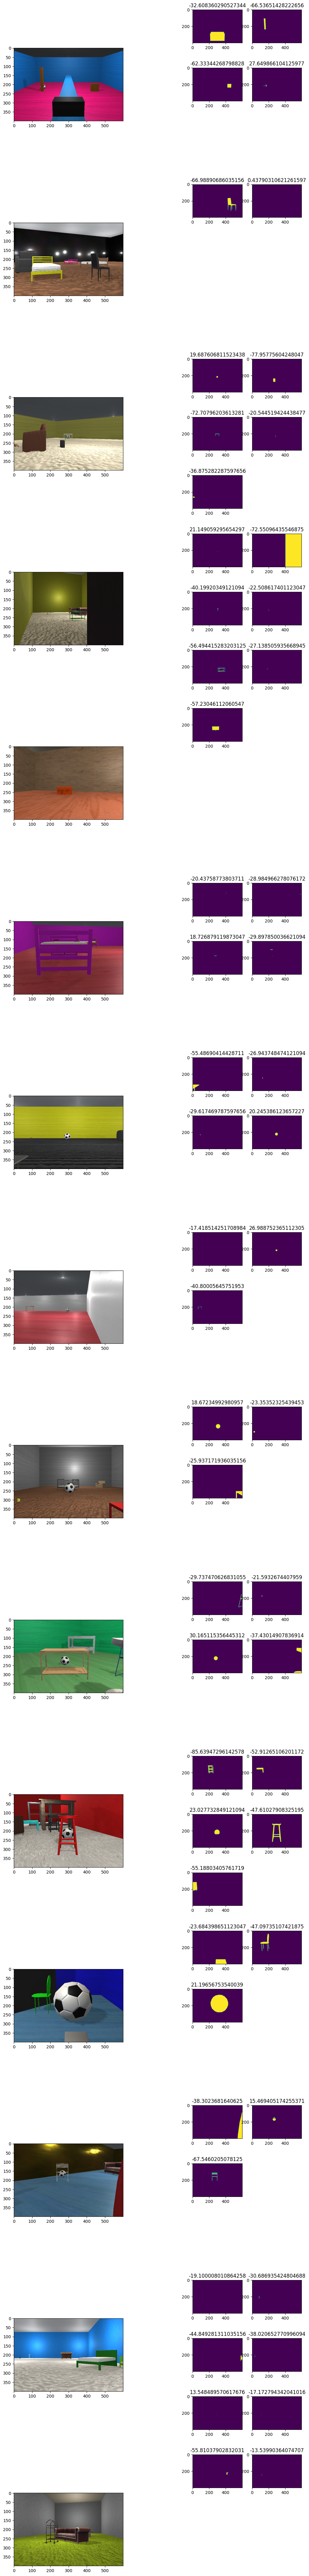

In [6]:
file_paths = [f'./spatial_elimination_eval_5_ex_2.json'] + [f'ball_scenes_bk_2/pr_10_{i:06}.json' for i in range(1000,1015)]

fig = plt.figure(figsize=(20,120))
fig.tight_layout()
num_cols = 5
num_rows = 48
big_size = 3
gs = GridSpec(nrows=num_rows, ncols=big_size + num_cols)

for i,im in enumerate(file_paths[:15]):
    scene_data = mcs.load_scene_json_file(im)
    s = controller.start_scene(scene_data)
    v_d, v_r, v_m = process_data(s)
    ax0 = fig.add_subplot(gs[i*big_size:(i+1)*big_size,:big_size-1])
    ax0.imshow(s.image_list[-1])
    all_ids = jnp.unique(v_m)
    added = 0
    ids_im = jax.vmap(jax.vmap(get_id_from_masks, in_axes=(None, 0)), in_axes=(None, 0))(
        jnp.array((0, 0, 0), dtype=jnp.uint8), jnp.asarray(s.object_mask_list[-1])
    )
    for o,im_id in enumerate(all_ids):
        mask = (v_m == im_id)
        if mask.sum()>500:
            continue
        colored_pc = process_object(im_id, mask)
        pred_logit = eval_m.apply({'params':params}, colored_pc).item()
        ax = fig.add_subplot(gs[i*big_size + math.floor(added/2), big_size + (added % 2)])
        ax.imshow(ids_im==im_id)
        ax.title.set_text(f'{pred_logit}')
        added += 1
        if added >5:
            break

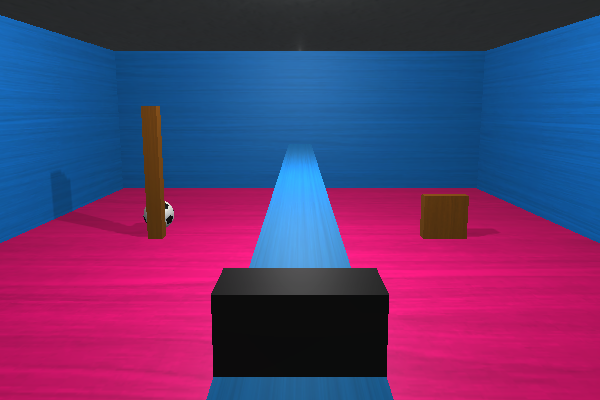

In [12]:
s.image_list[-1]